http://www.scipy-lectures.org/packages/scikit-learn/index.html

http://nbviewer.ipython.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

Make sure you have scikit-learn and seaborn installed:

In Windows, open a new command window, and enter the following:

    cd C:\bw2-python\
    bw2-env.bat
    conda install -y -q seaborn scikit-learn
    
In OS X, open a new terminal window, and enter the following:

    source ~/bw2-python/envs/bw2/bin/activate
    conda install -y -q seaborn scikit-learn
    

In [1]:
from brightway2 import *
import xlrd
import numpy as np
import pyprind
import sklearn.cluster as cluster
import time

In [2]:
if 'Class 3' not in projects:
    projects.current = "Class 1"
    projects.copy_project("Class 3")

In [3]:
projects.current = "Class 3"

In [4]:
list(databases)

['motorcycles', 'biosphere3', 'ecoinvent 2.2']

# Motorcycle physics model

In [5]:
class Motorcycle(object):
    def __init__(self, dry_weight, displacement, power, fuel_capacity, name, year, **kwargs):
        # ~0.6 kg/l density of gasoline, assume half full, 10l if no info
        self.mass = dry_weight + (fuel_capacity or 10.) * 0.6  * 0.5  
        self.power = power
        self.displacement = displacement
        self.name = name
        self.year = year
        self.ttw = self.get_ttw()
        self.idling_consumption = 1.
        self.Af = self.get_Af()
        self.coefficient_drag = 0.6
        self.coefficient_resist = 0.01
        self.recup_efficiency = 0.  # No electric bikes, no recuperation

    def get_ttw(self):
        return 0.15 * 1.04 ** (self.year - 2015)

    def get_Af(self):
        if self.displacement < 50:
            return 0.4
        elif self.displacement < 100:
            return 0.5
        elif self.displacement < 500:
            return 0.6
        else:
            return 0.8

In [6]:
class MotorcycleEnergyConsumption(object):
    def __init__(self):
        self.cycles = self.get_driving_cycles()
        self.RHO_AIR = 1.2  # air density for aerodynamic calculations

    def get_driving_cycles(self):
        wb = xlrd.open_workbook("files/WMTC.xlsx")
        ws = wb.sheet_by_name("Sheet1")
        headers = [ws.cell(0, x).value for x in range(1, ws.ncols)]
        return {header: np.array([float(ws.cell(row, index + 1).value)
                                  for row in range(1, ws.nrows)
                                  if ws.cell(row, index + 1).value != ''])
                for index, header in enumerate(headers)}

    def get_section_weights(self, displacement):
        if displacement < 100:
            return (slice(600),), (1.,)
        elif displacement < 500:
            return (slice(600), slice(600, 1200)), (0.3, 0.7, 0)
        else:
            return (slice(600), slice(600, 1200), slice(1200, 1800)), (0.25, 0.5, 0.25)

    def get_driving_cycle(self, displacement):
        if displacement < 100:
            return self.cycles[1.1]
        elif displacement < 500:
            return self.cycles[2.1]
        else:
            return self.cycles[3.2]

    def get_energy_consumption(self, bike):
        def slice_and_sum(lst):
            obj = [lst[sl].sum() / 1000. for sl in slices]
            obj.append(add_weighted_sum(obj))
            return np.array(obj)

        cycle = self.get_driving_cycle(bike.displacement)
        slices, weights = self.get_section_weights(bike.displacement)

        velocity = cycle / 3.6  # Unit conversion?
        acceleration = velocity * 0
        acceleration[:-1] = velocity[1:] - velocity[:-1]

        kinetic_force = acceleration * bike.mass
        rolling_resistance = np.ones(cycle.shape) * bike.mass * bike.coefficient_resist * 9.81
        air_resistance = (velocity ** 2 * bike.coefficient_drag
                          * bike.Af * self.RHO_AIR / 2)

        # Total force required at the wheel to meet acceleration requirement. rolling and
        # air resistance are always positive (resisting motion) but kinetic force
        # can be negative, when the bike is decelerating.
        total_force = kinetic_force + rolling_resistance + air_resistance
        power = total_force * velocity
        idling = (velocity == 0) * 1

        arrays = np.recarray(
            velocity.shape,
            dtype=[(col, float) for col in 'kraw']
        )

        arrays.k = kinetic_force * velocity
        arrays.r = rolling_resistance * velocity
        arrays.a = air_resistance * velocity
        arrays.w = power  # arrays.k + arrays.r + arrays.a

        decelerating = total_force < 0

        pa = arrays.copy()
        pa[decelerating] = (0,0,0,0)  # Four columns of zeros; special handling for recarrays
        pd = arrays.copy()
        pd[~decelerating] = (0,0,0,0)

        recuperated_power = pd.w * bike.recup_efficiency

        add_weighted_sum = lambda lst: sum([x * y for x, y in zip(lst, weights)])

        # Convert to km; velocity is m/s, times 1 second
        distance = slice_and_sum(velocity)

        ttw_idle = [idling[sl].sum() * bike.idling_consumption for sl in slices]
        ttw_idle.append(add_weighted_sum(ttw_idle))
        ttw_idle = np.array(ttw_idle)

        return (
            slice_and_sum(pa.w) / distance,  # Traction
            ttw_idle / distance,             # Idling
            slice_and_sum(recuperated_power) / distance / bike.ttw,  # Recuperated
            slice_and_sum(pa.k) / distance / bike.ttw,  # Kinetic
            slice_and_sum(pa.r) / distance / bike.ttw,  # Rolling
            slice_and_sum(pa.a) / distance / bike.ttw   # Aero
        )

    def __call__(self, bike):
        return sum([x[-1] # Only want last number, which is average
                   for x in self.get_energy_consumption(bike)
                   ]) / 1000.  # Convert to kWh

In [7]:
mec = MotorcycleEnergyConsumption()

## Test motorcycle

Test motorcycle is 4 kW moped. Run over a test cycle of ~10 minutes, should use around half a kilowatt hour.

In [8]:
test_motorcycle = Motorcycle(155, 50, 0, 0, 'foo', 2010)
mec(test_motorcycle)

0.465311680018342

# Motorcycle database

We scraped http://www.motorcycledb.com/ for data on alomst 7000 motorcycles.

In [9]:
def get_motorcycle_database():
    wb = xlrd.open_workbook("files/motorcycles.xlsx")
    ws = wb.sheet_by_name("Sheet1")
    columns = ['name', 'dry_weight', 'power', 'fuel_capacity', 'displacement', 
               'engine_type', 'model', 'category', 'year']
    return [{col: ws.cell(row, index + 1).value
             for index, col in enumerate(columns)}
           for row in range(1, ws.nrows)]

In [10]:
motorcycles = [obj for obj in get_motorcycle_database()
               if obj['displacement']
               and obj['engine_type'] != 'Electric']

Make sure names are unique

In [11]:
motorcycles = list({obj['name']: obj for obj in motorcycles}.values())

In [12]:
len(motorcycles)

6853

In [13]:
for obj in motorcycles:
    # Convert from kWh to kg gasoline: 12.33 kWh / kg gasoline
    obj['energy'] = mec(Motorcycle(**obj)) / 12.33  # kg gasoline / km
    obj['co2'] = obj['energy'] * 3.2338  # kg CO2/km, assume constant factor
    obj['nox'] = 0.0001 * np.exp(-0.045 * (int(obj['year'] - 2015))) # kg NOx / km

In [14]:
motorcycles[0]

{'category': 'Custom / cruiser',
 'co2': 0.25603949566098405,
 'displacement': 399.0,
 'dry_weight': 275.0,
 'energy': 0.079176045414368248,
 'engine_type': 'V2, four-stroke',
 'fuel_capacity': 15.0,
 'model': 'Suzuki Intruder Classic 400',
 'name': 'Suzuki Intruder Classic 400 (2012)',
 'nox': 0.00011445367843513146,
 'power': 33.0,
 'year': 2012.0}

# LCI inventories

In [15]:
db = Database('ecoinvent 2.2')
scooter_maintenance = db.search('maintenance scooter')[0]  # Assumes 90 kg of mass
scooter_disposal = db.search('disposal scooter')[0]
scooter_body = db.search("scooter regional storage")[0]
petrol = db.search("petrol low-sulphur regional storage")[1]
db = Database('biosphere3')
co2 = db.search("carbon dioxide fossil")[0]
nox = db.search("nitrogen oxides")[0]

Check to make sure the searching worked

In [16]:
scooter_maintenance, scooter_disposal, scooter_body, petrol, co2, nox

('maintenance, scooter' (unit, CH, ['transport systems', 'road']),
 'disposal, scooter' (unit, CH, ['transport systems', 'road']),
 'scooter, ICE, at regional storage' (unit, RER, ['transport systems', 'road']),
 'petrol, low-sulphur, at regional storage' (kilogram, RER, ['oil', 'fuels']),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Nitrogen oxides' (kilogram, None, ('air',)))

Add LCI data

In [17]:
for obj in motorcycles:
    obj['unit'] = 'person kilometer'
    obj['exchanges'] = [
        {'input': co2.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['co2'],
         'uncertainty type': 0,
         'type': 'biosphere'
        },
        {'input': nox.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['nox'],
         'uncertainty type': 0,
         'type': 'biosphere'
        },
        {'input': scooter_maintenance.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': scooter_disposal.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': scooter_body.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['dry_weight'] / 90. * 1.81e-5,
         'uncertainty type': 0,
         'type': 'technosphere'
        },
        {'input': petrol.key,
         'output': ('motorcycles', obj['name']),
         'amount': obj['energy'],
         'uncertainty type': 0,
         'type': 'technosphere'
        },
    ]

Create and write database

In [18]:
db = Database("motorcycles")

In [ ]:
db.write({('motorcycles', obj['name']): obj for obj in motorcycles})

# Add LCA results to motorcycle database

In [19]:
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')
smog = ('ReCiPe Endpoint (E,A)', 'human health', 'photochemical oxidant formation')

In [20]:
lca = LCA({db.random(): 1}, method=gwp)
lca.lci(factorize=True)
lca.lcia()

In [21]:
for obj in pyprind.prog_bar(motorcycles):
    lca.redo_lcia({('motorcycles', obj['name']): 1})
    obj['gwp'] = lca.score

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 38.505 sec


In [22]:
lca.method = smog
lca.load_lcia_data()

In [23]:
for obj in pyprind.prog_bar(motorcycles):
    lca.redo_lcia({('motorcycles', obj['name']): 1})
    obj['smog'] = lca.score

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 38.736 sec


In [24]:
%matplotlib inline

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

sns.set(style="white", palette="muted", color_codes=True, context='poster')

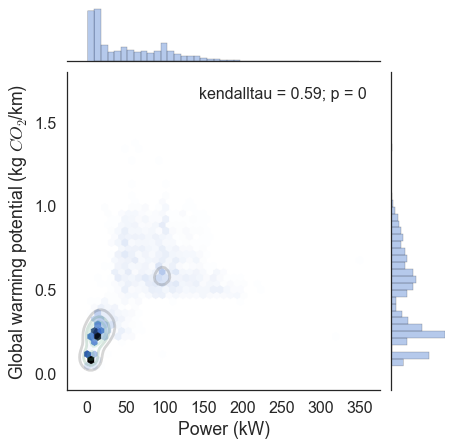

In [26]:
sns.jointplot(
    np.array([x['power'] for x in motorcycles]),
    np.array([x['gwp'] for x in motorcycles]),
    kind='hex',
    stat_func=kendalltau,
).plot_joint(sns.kdeplot, zorder=1, n_levels=6, alpha=0.2)
plt.xlabel("Power (kW)")
plt.ylabel(r"Global warming potential (kg $CO_{2}$/km)")

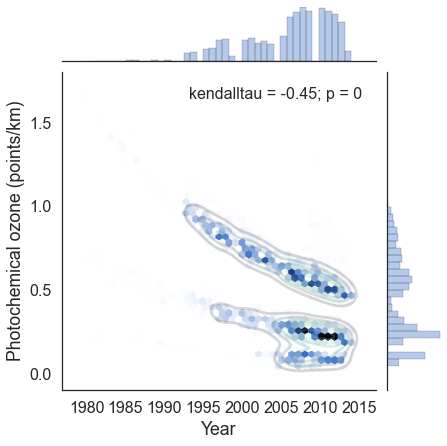

In [27]:
sns.jointplot(
    np.array([x['year'] for x in motorcycles]),
    np.array([x['smog'] for x in motorcycles]),
    kind='hex',
    stat_func=kendalltau,
).plot_joint(sns.kdeplot, zorder=1, n_levels=6, alpha=0.2)
plt.xlabel("Year")
plt.ylabel("Photochemical ozone (points/km)")

What are our continuous, numerical variables?

* displacement
* power
* dry_weight
* co2
* smog
* year

In [28]:
data = np.array([[
    obj['displacement'],
    obj['power'],
    obj['dry_weight'],
    obj['co2'],
    obj['smog'],
    obj['year'],
    obj['energy']
] for obj in motorcycles])
data.shape

(6853, 7)

In [29]:
plot_kwds = {'alpha' : 0.1, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    print('Clustering took {:.2f} s'.format(time.time() - start_time))

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    plt.figure(0)
    plt.scatter(data.T[1], data.T[3], c=colors, **plot_kwds)
    plt.xlabel("Power (kW)")
    plt.ylabel(r"Global warming potential (kg $CO_{2}$/km)")    

    plt.figure(1)
    plt.scatter(data.T[0], data.T[2], c=colors, **plot_kwds)
    plt.xlabel("Displacement (CC)")
    plt.ylabel("Dry weight (kg)")    

    plt.figure(2)
    plt.scatter(data.T[6], data.T[5], c=colors, **plot_kwds)
    plt.xlabel("Energy (kWh/km)")
    plt.ylabel("Year")    

Clustering took 0.05 s


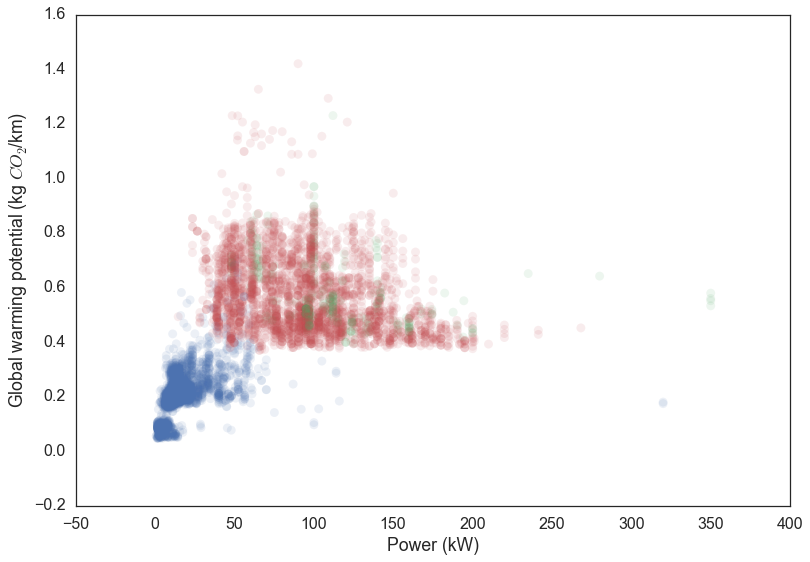

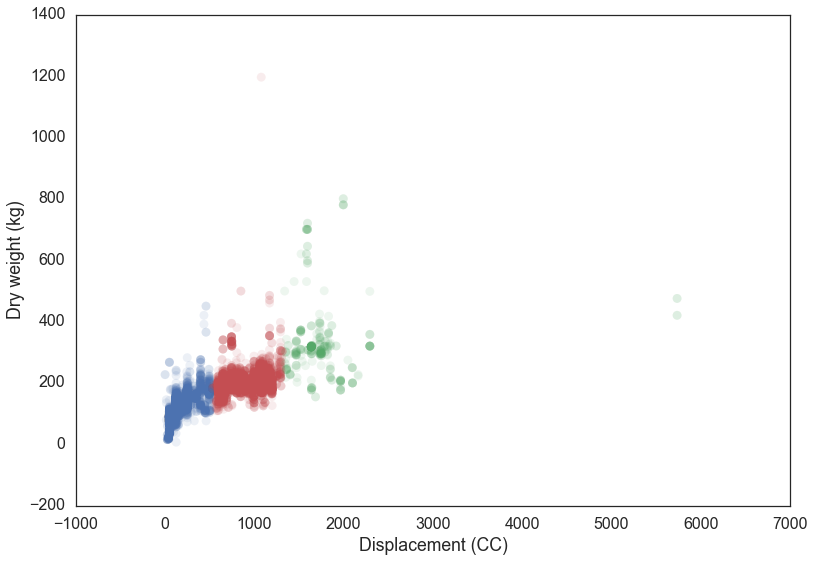

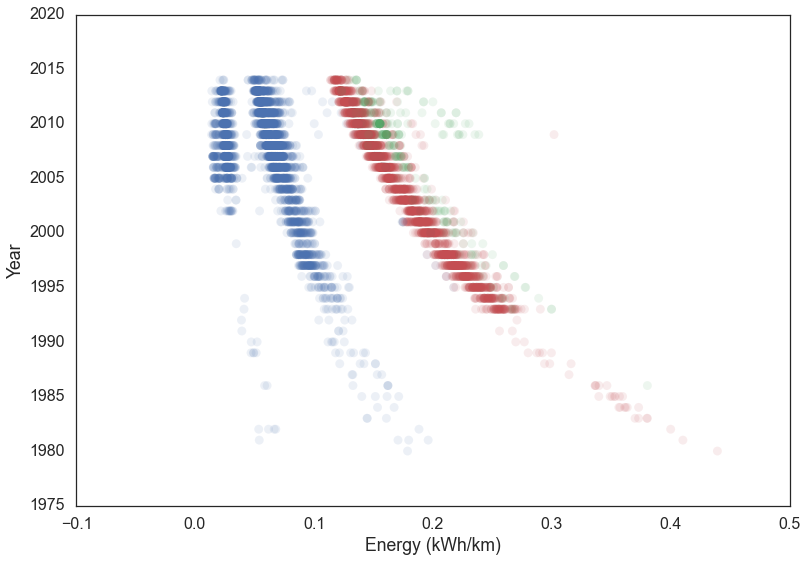

In [30]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters': 3})

Clustering took 0.07 s


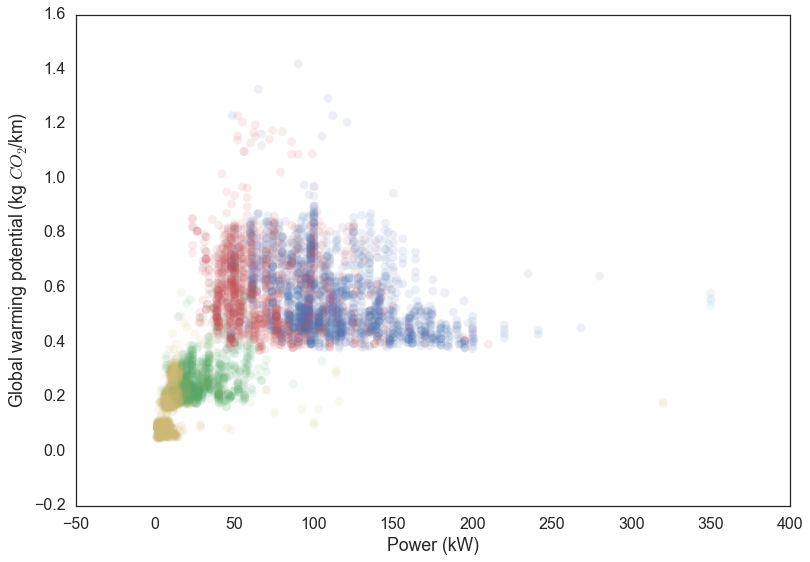

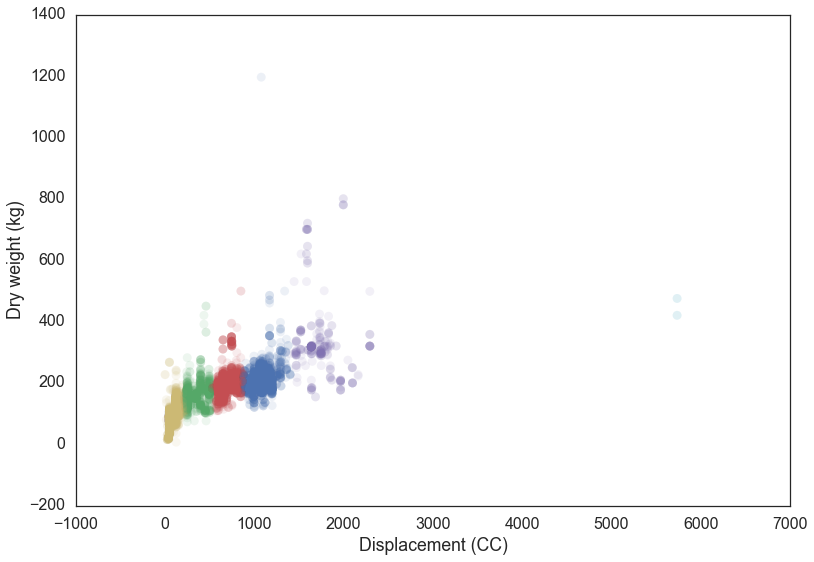

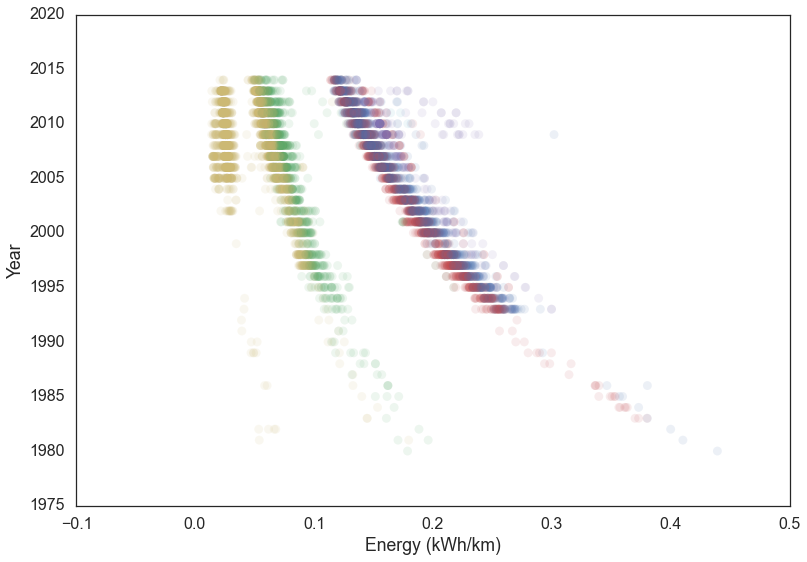

In [33]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters': 6})

Clustering took 169.78 s


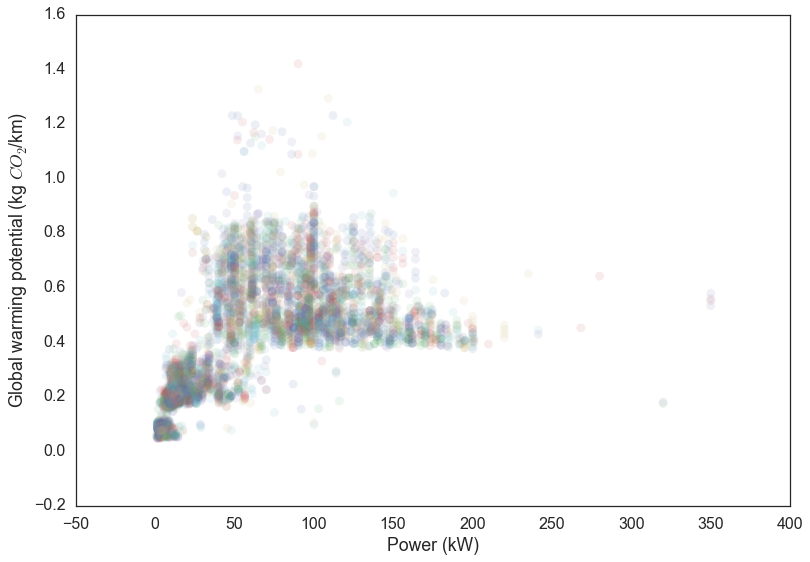

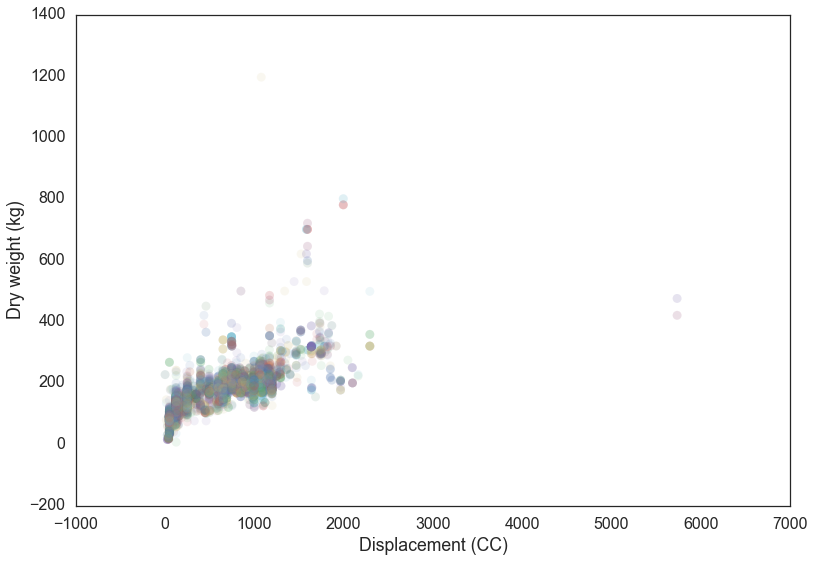

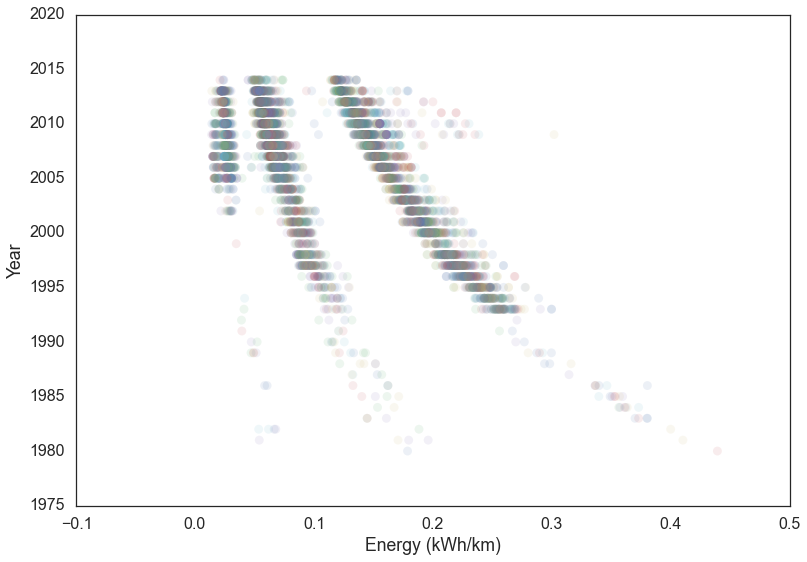

In [32]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [34]:
from sklearn.decomposition import PCA, FactorAnalysis

In [54]:
pca = PCA(4)

In [55]:
pca.fit(data)

PCA(copy=True, n_components=4, whiten=False)

In [56]:
pca.components_

array([[  9.89655233e-01,   8.54176504e-02,   1.15255393e-01,
          3.28887637e-04,   3.93376328e-04,  -1.50534770e-03,
          1.01703147e-04],
       [  9.89772748e-02,   1.75073268e-01,  -9.79550052e-01,
         -7.48640941e-04,  -9.78666228e-04,   5.74231260e-03,
         -2.31505022e-04],
       [ -1.03849050e-01,   9.80836862e-01,   1.64821287e-01,
          1.10800737e-03,   1.29976372e-03,   2.30961379e-03,
          3.42633239e-04],
       [  1.16729164e-03,  -3.09336419e-03,   5.46374568e-03,
         -1.98140948e-02,  -2.28111338e-02,   9.99504241e-01,
         -6.12718621e-03]])

In [57]:
pca.explained_variance_ratio_

array([  9.87840024e-01,   9.39717763e-03,   2.62395074e-03,
         1.38773204e-04])

In [58]:
transformed_data = pca.fit_transform(data)

In [59]:
transformed_data.shape

(6853, 4)

In [60]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    print('Clustering took {:.2f} s'.format(time.time() - start_time))

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.xlabel("Axis 1")
    plt.ylabel("Axis 2")    

Clustering took 0.04 s


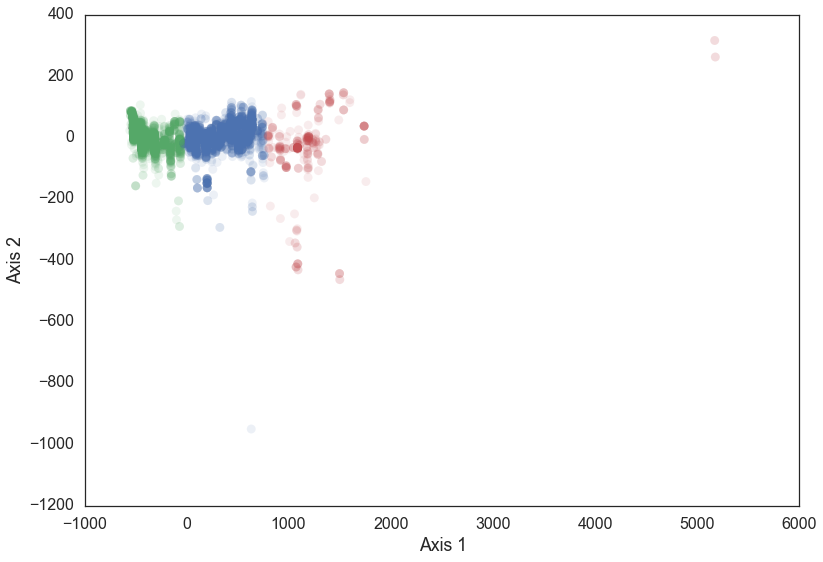

In [61]:
plot_clusters(transformed_data, cluster.KMeans, (), {'n_clusters': 3})